In [1]:
import h5py  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [3]:
#If using GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#read database.
f = h5py.File('GWdatabase.h5','r')   
f.keys()   

<KeysViewHDF5 ['reduced_data', 'waveforms', 'yeofrho']>

In [4]:
#create a list that contains all the failure cases.
fail_list = []
index = 0
for item in f['reduced_data']['tbounce(s)']:
    if(item == -1):
        fail_list.append(index)
    index += 1

In [6]:
#get the label of the data for EOS
labels = []
index = 0
index_fail = 0
for item in f['reduced_data']['EOS']:
    if(index != fail_list[index_fail]):
        labels.append(str(item))
    else:
        index_fail += 1
    index += 1

In [7]:
#tranform the label to what it should be.
labels = np.array(labels)
labels = np.where(labels == "b'SFHo_ecapture_0.1'", "b'SFHo'", labels)
labels = np.where(labels == "b'SFHo_ecapture_1.0'", "b'SFHo'", labels)
labels = np.where(labels == "b'SFHo_ecapture_10.0'", "b'SFHo'", labels)

In [7]:
#get the label of w.
labels = []
index = 0
index_fail = 0
for a in f['waveforms']:
    if(index != fail_list[index_fail]):
        labels.append(a.split('_')[0].split('w')[1])
    else:
        index_fail += 1
    index += 1

['0.50']


In [8]:
#signal preprocessing used by the paper.(We don't need it.)
from scipy import signal
from scipy.fft import fft, fftshift

<ipython-input-25-bc6fa5089ba6>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4, 4), dpi=64)


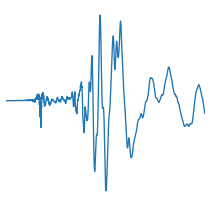

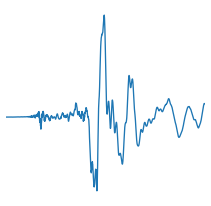

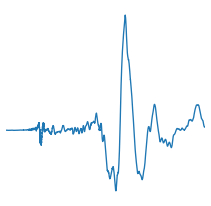

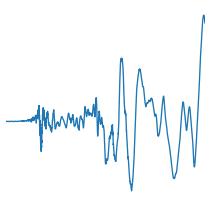

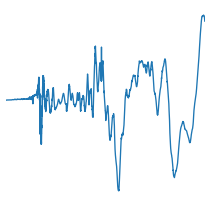

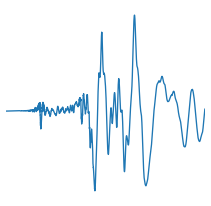

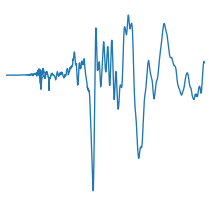

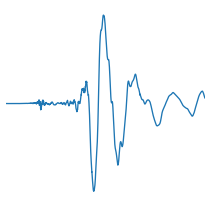

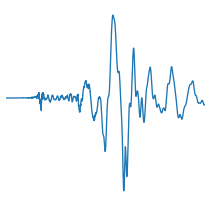

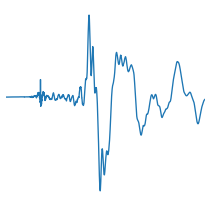

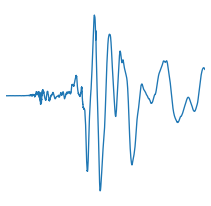

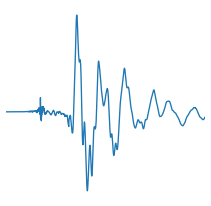

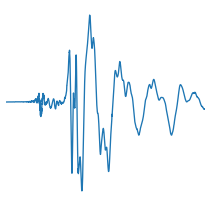

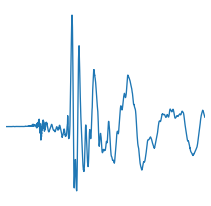

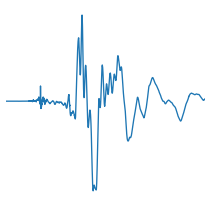

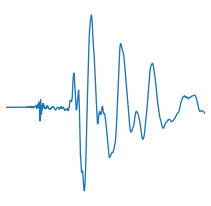

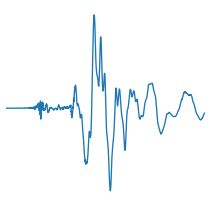

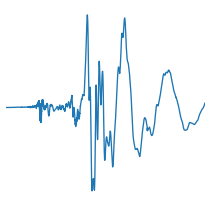

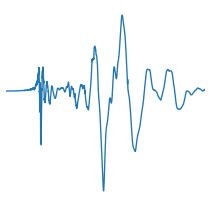

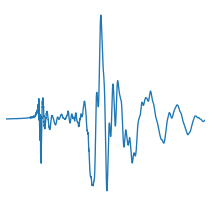

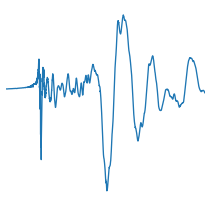

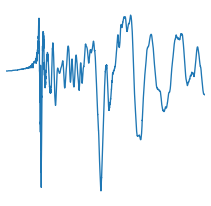

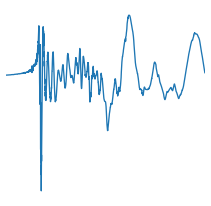

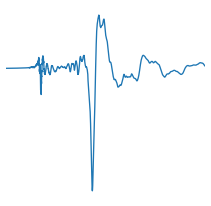

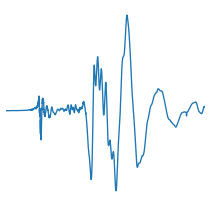

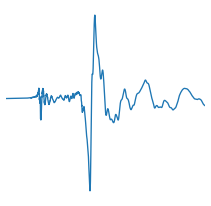

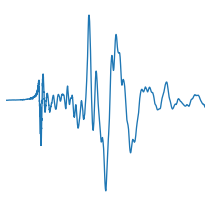

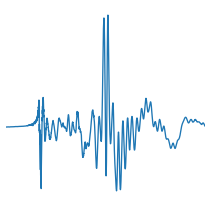

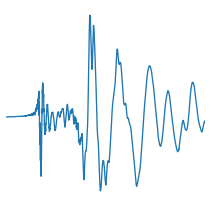

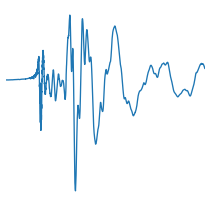

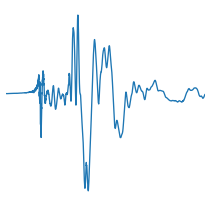

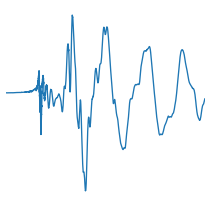

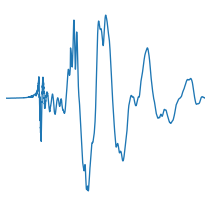

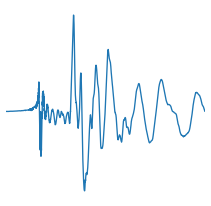

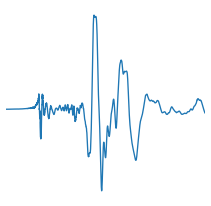

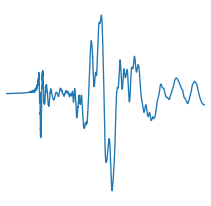

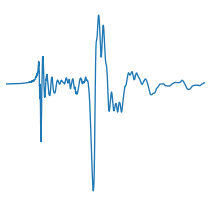

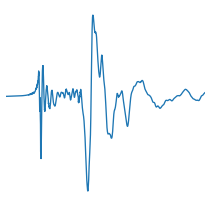

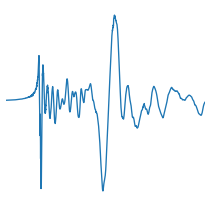

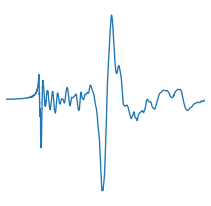

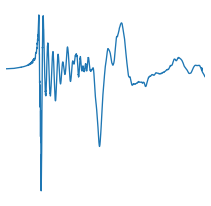

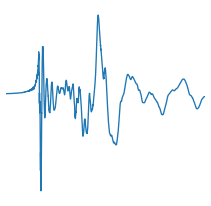

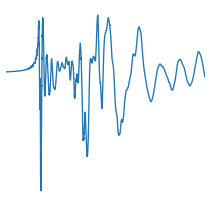

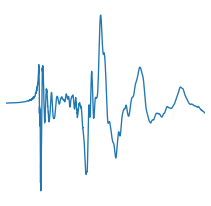

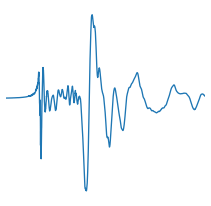

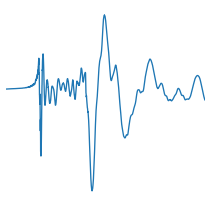

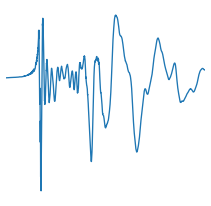

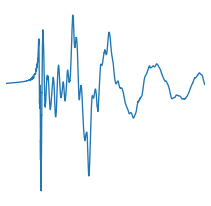

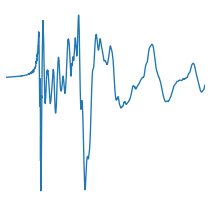

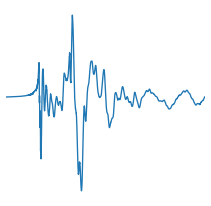

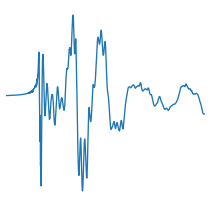

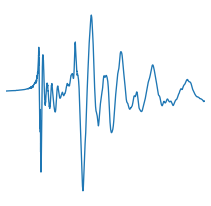

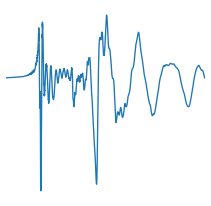

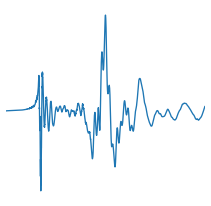

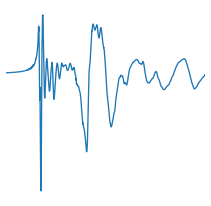

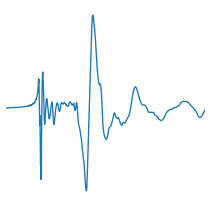

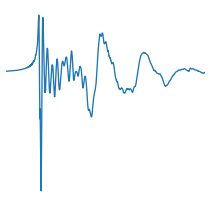

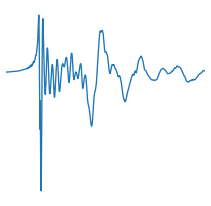

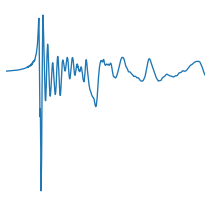

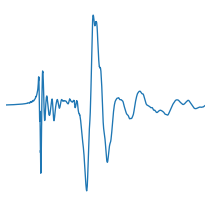

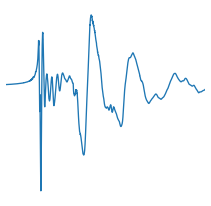

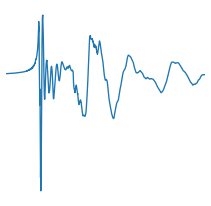

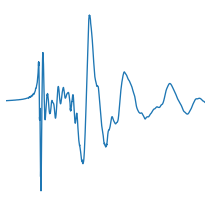

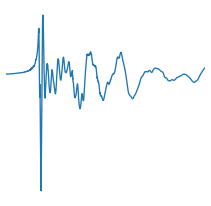

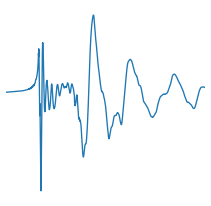

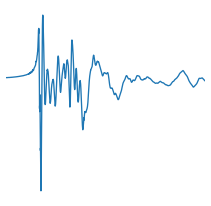

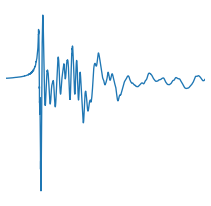

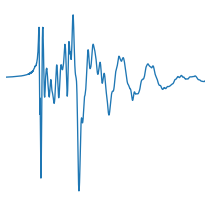

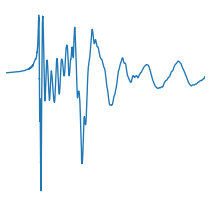

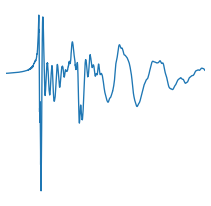

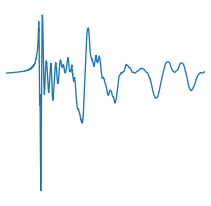

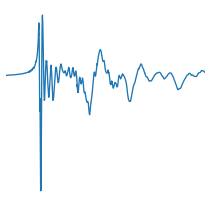

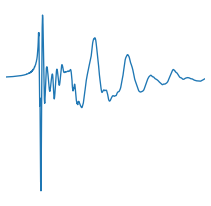

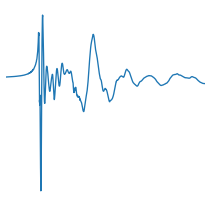

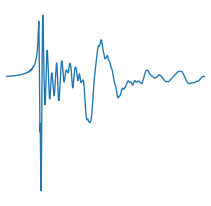

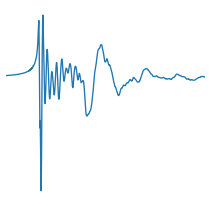

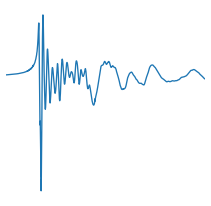

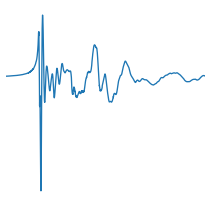

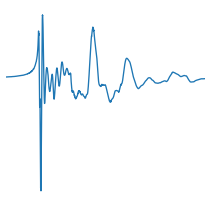

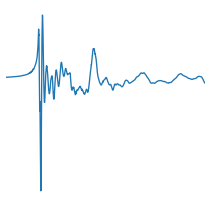

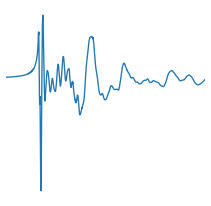

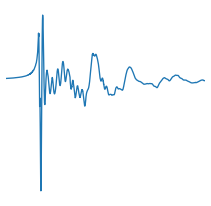

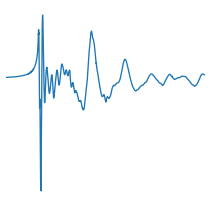

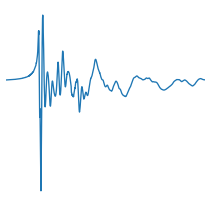

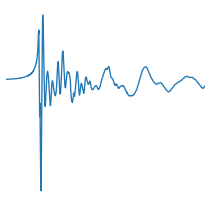

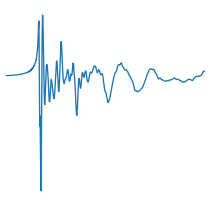

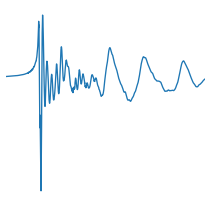

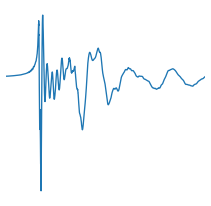

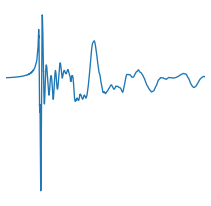

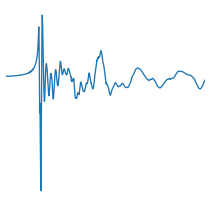

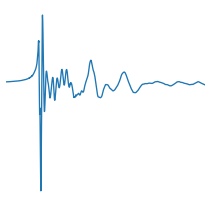

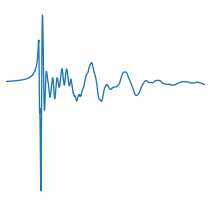

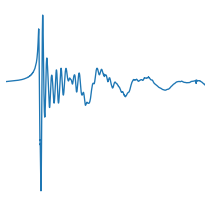

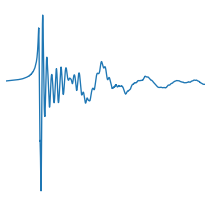

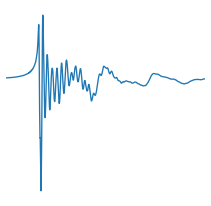

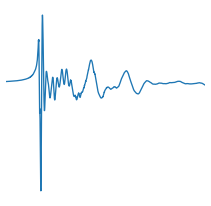

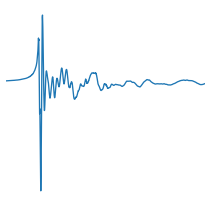

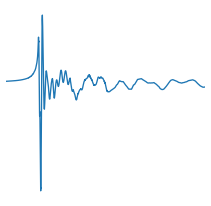

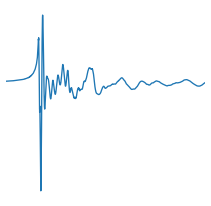

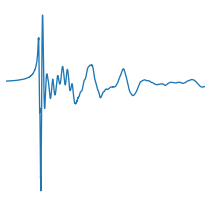

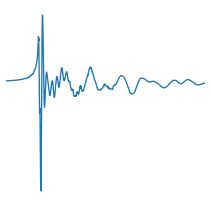

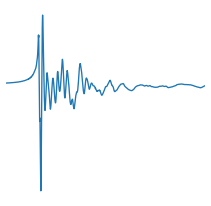

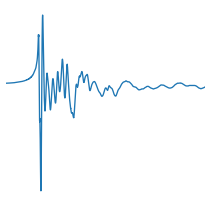

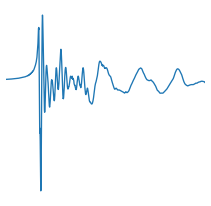

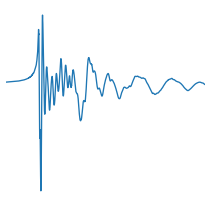

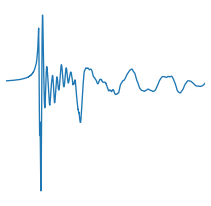

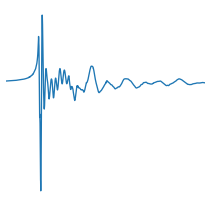

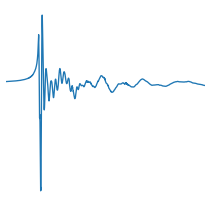

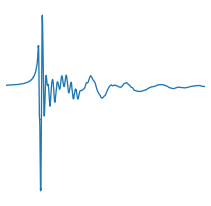

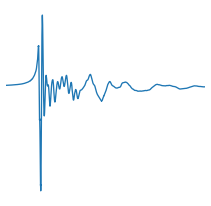

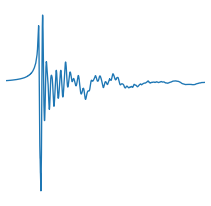

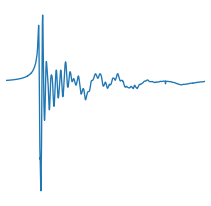

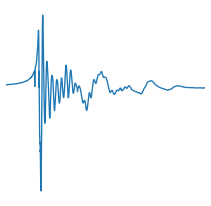

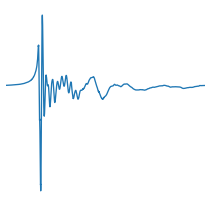

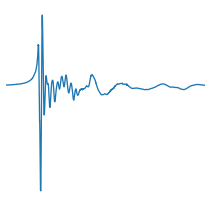

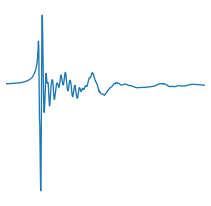

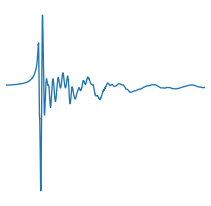

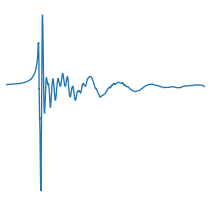

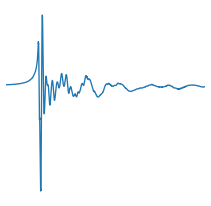

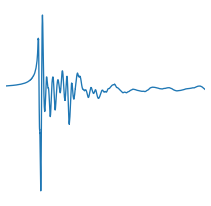

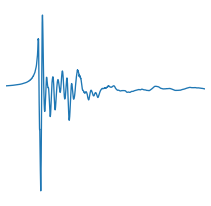

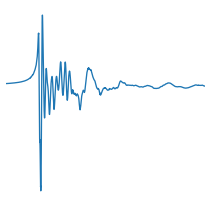

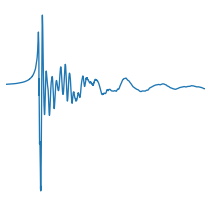

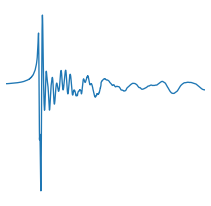

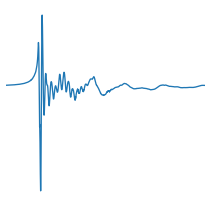

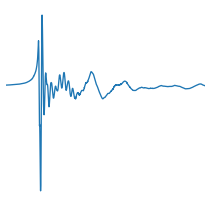

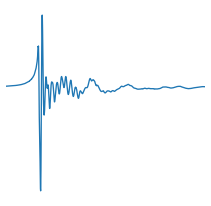

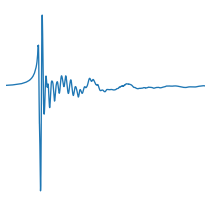

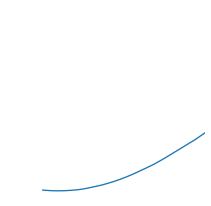

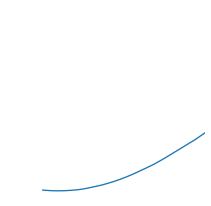

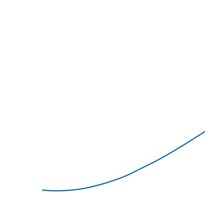

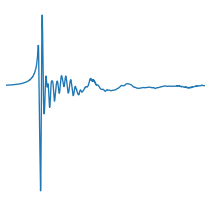

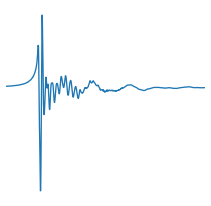

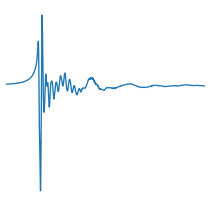

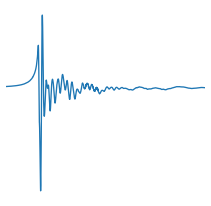

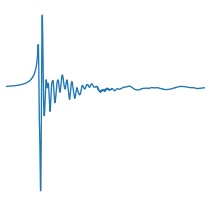

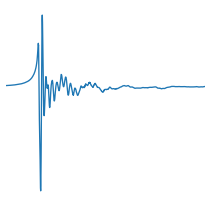

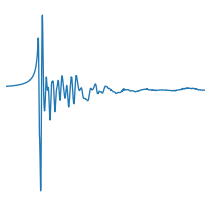

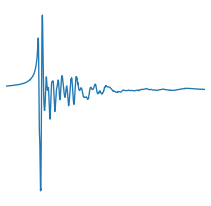

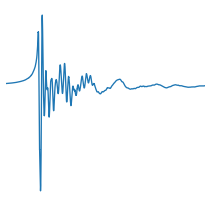

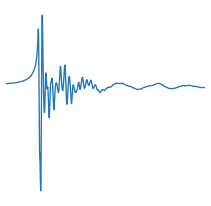

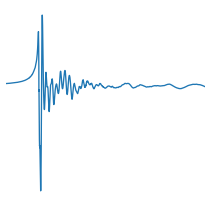

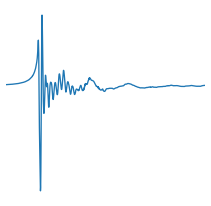

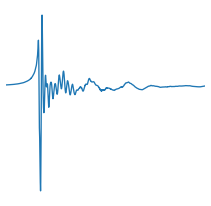

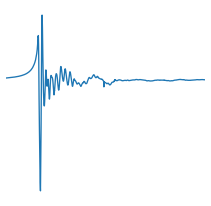

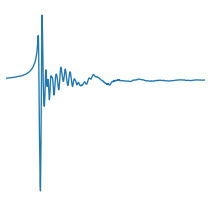

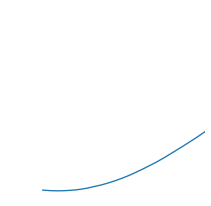

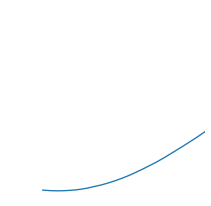

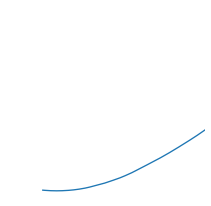

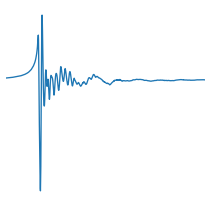

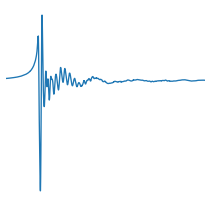

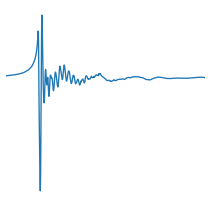

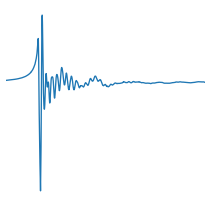

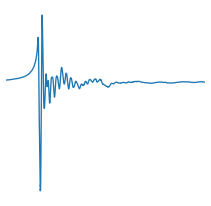

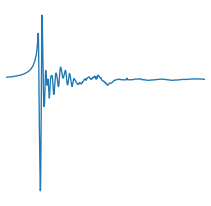

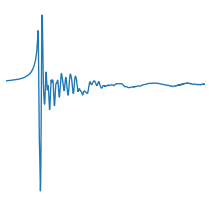

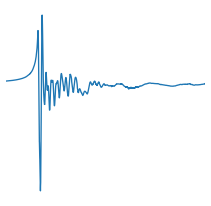

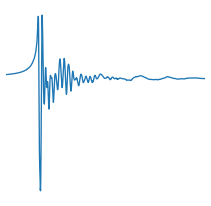

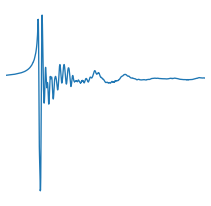

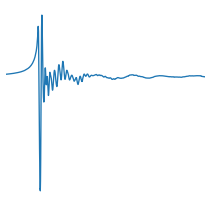

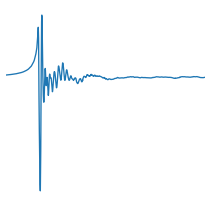

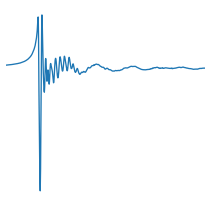

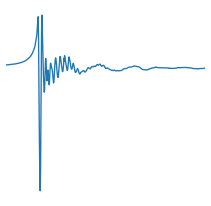

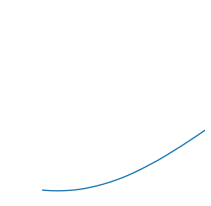

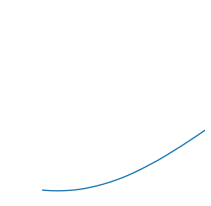

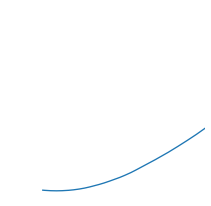

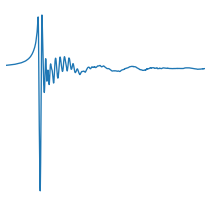

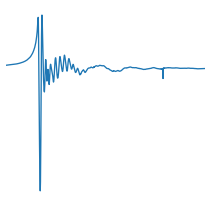

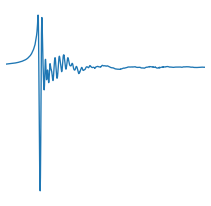

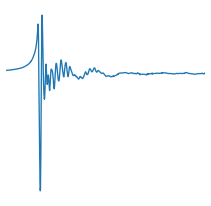

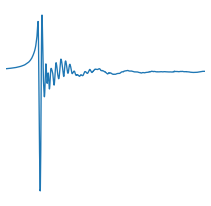

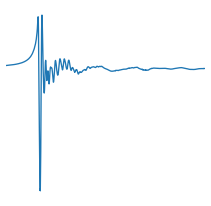

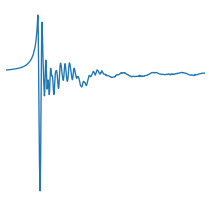

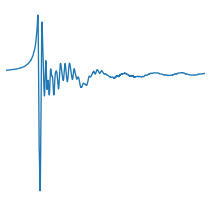

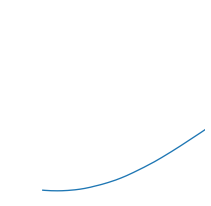

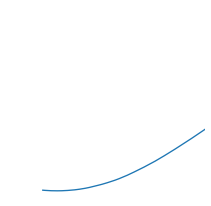

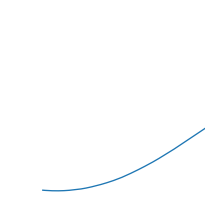

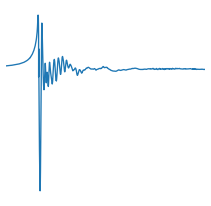

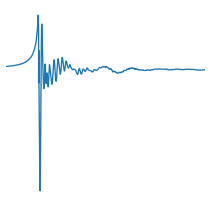

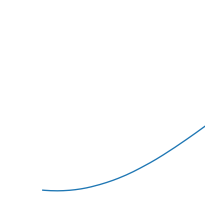

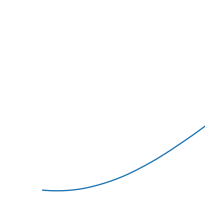

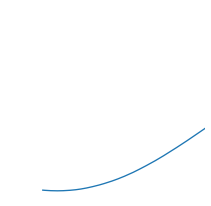

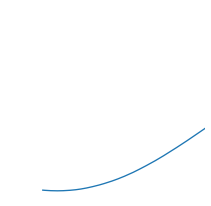

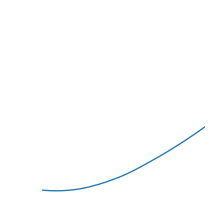

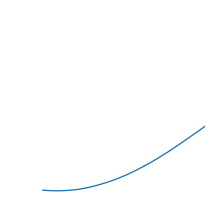

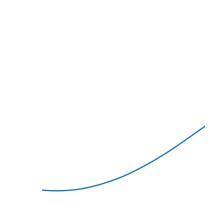

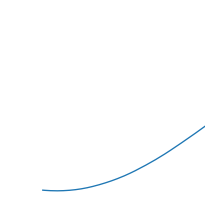

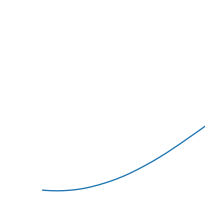

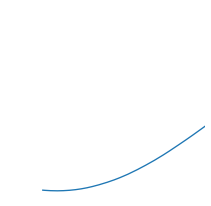

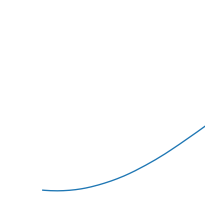

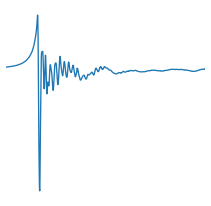

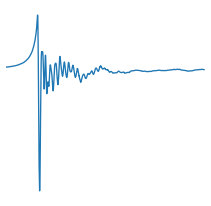

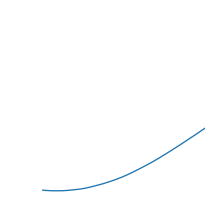

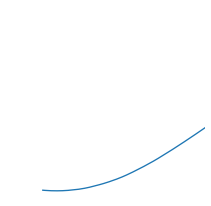

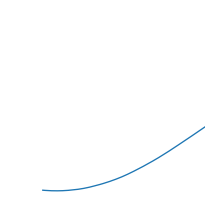

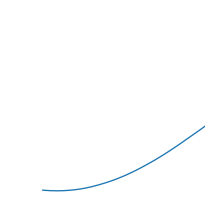

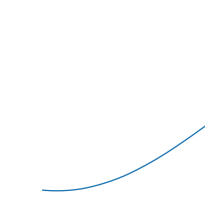

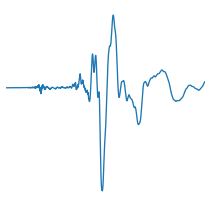

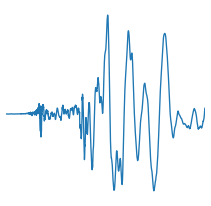

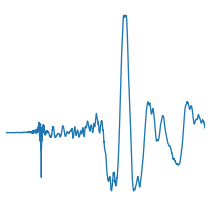

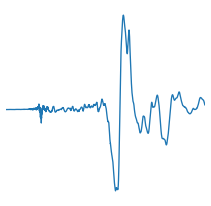

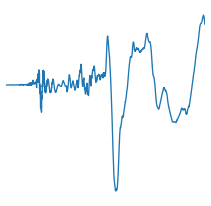

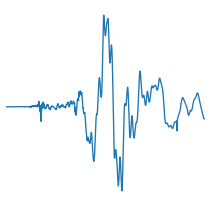

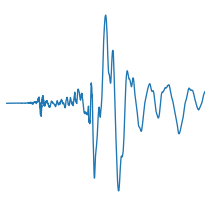

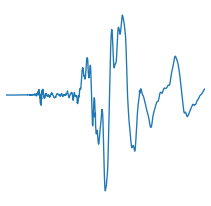

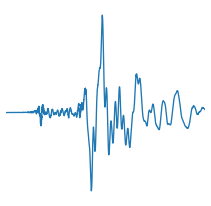

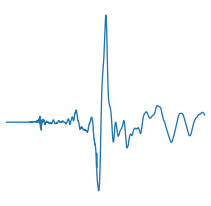

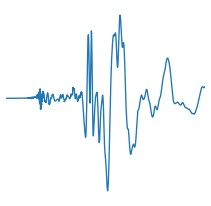

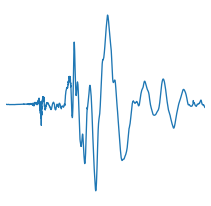

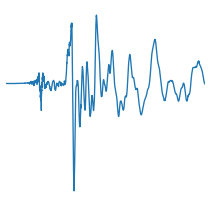

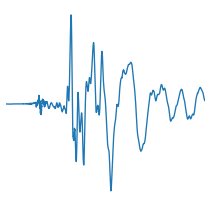

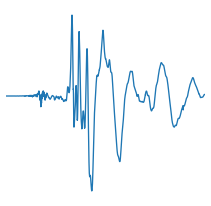

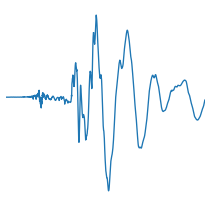

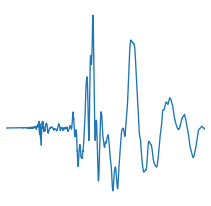

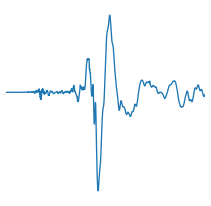

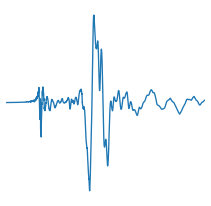

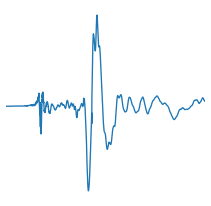

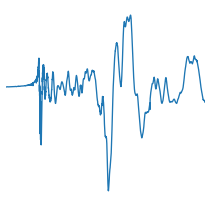

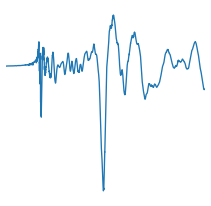

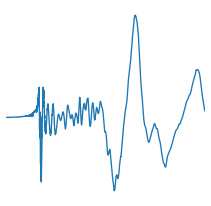

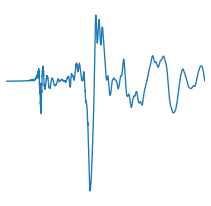

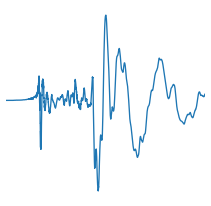

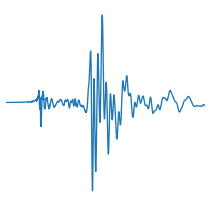

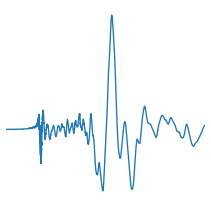

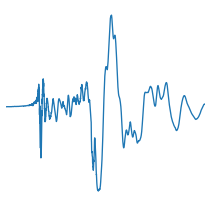

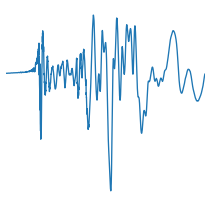

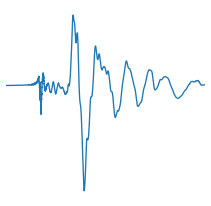

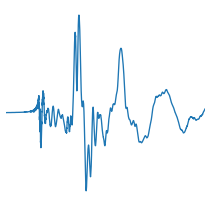

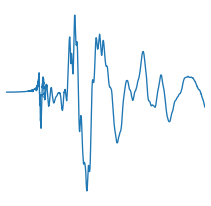

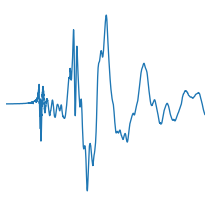

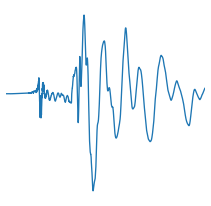

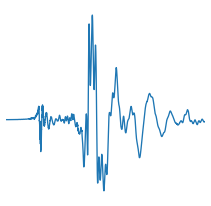

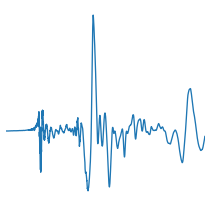

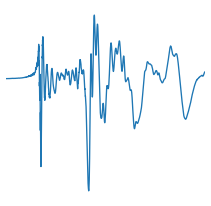

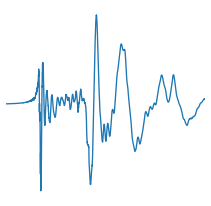

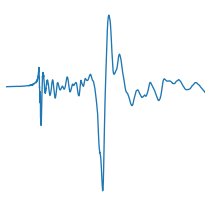

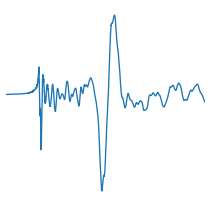

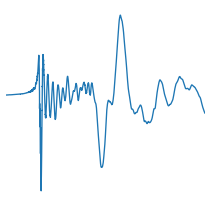

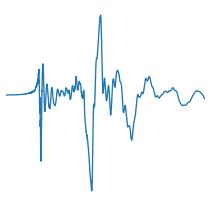

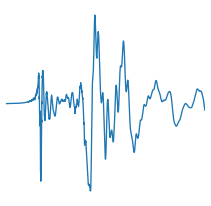

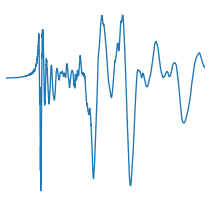

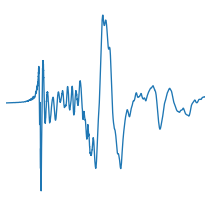

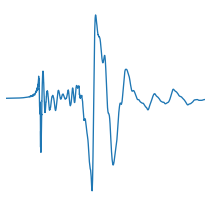

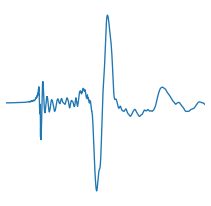

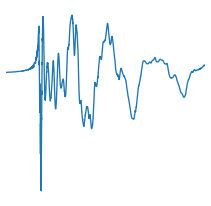

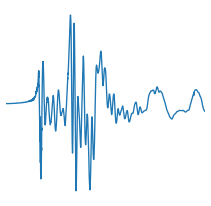

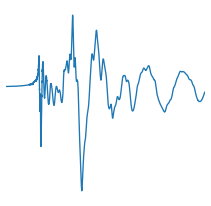

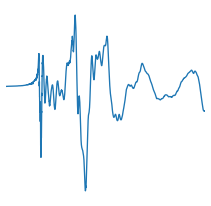

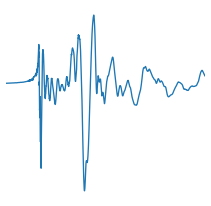

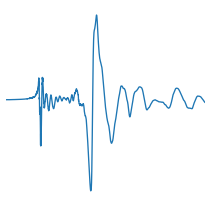

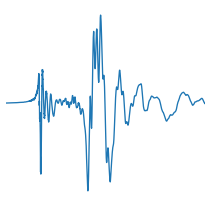

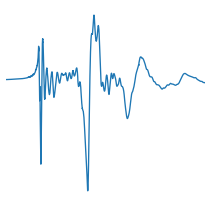

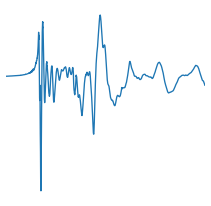

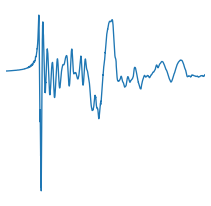

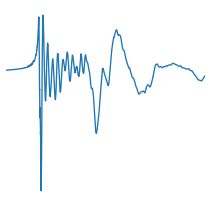

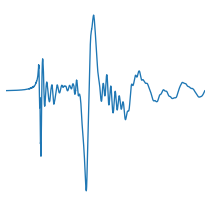

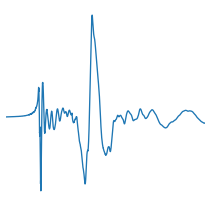

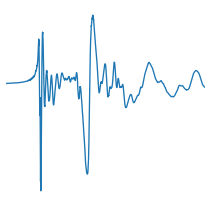

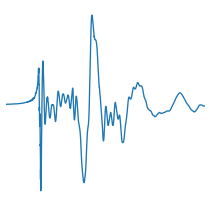

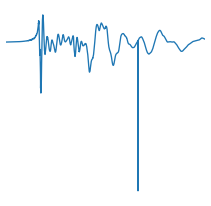

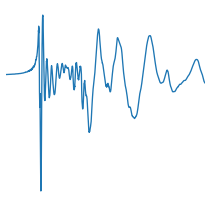

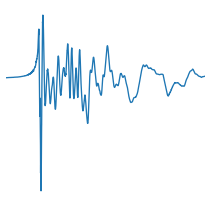

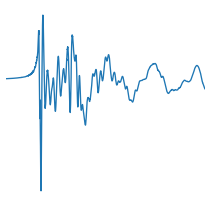

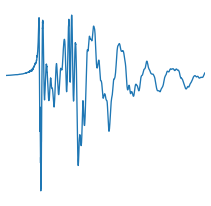

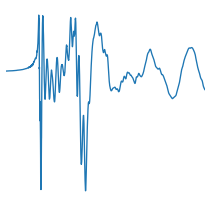

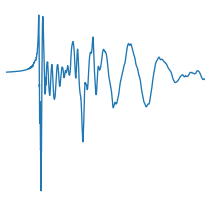

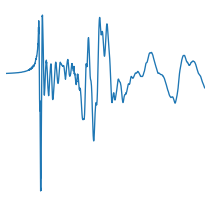

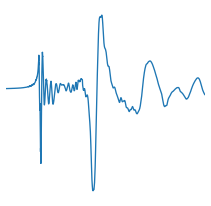

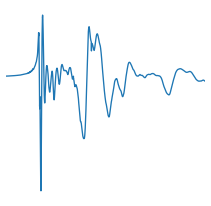

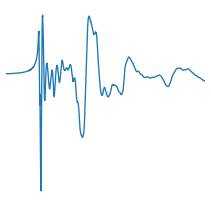

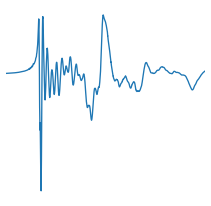

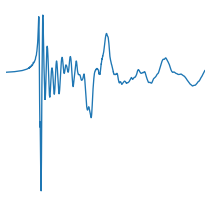

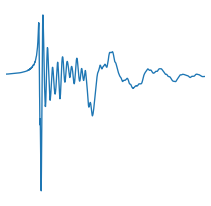

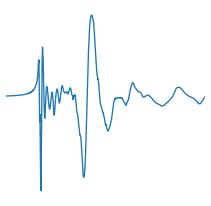

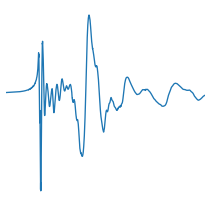

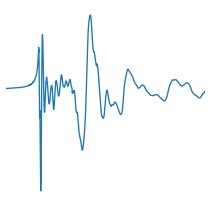

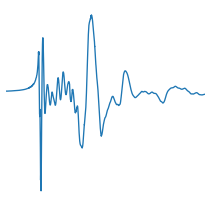

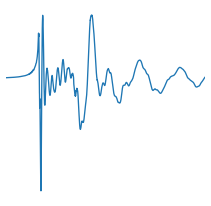

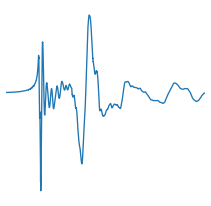

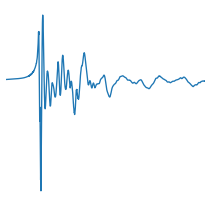

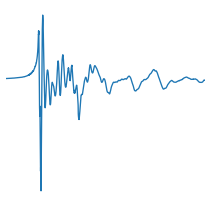

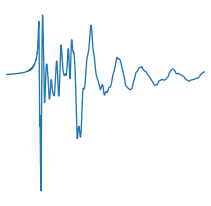

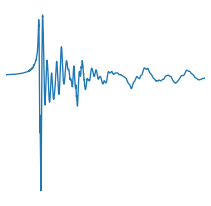

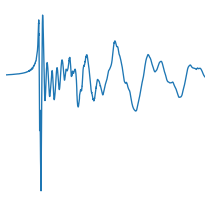

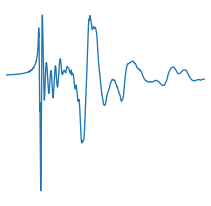

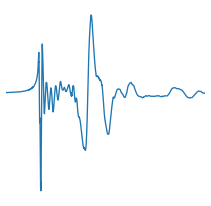

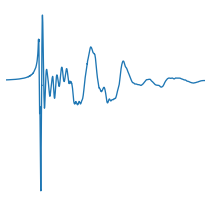

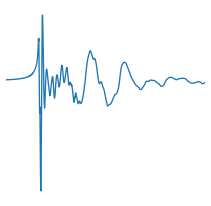

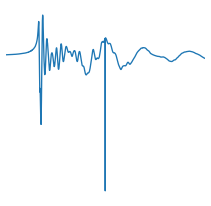

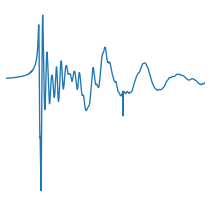

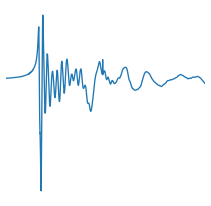

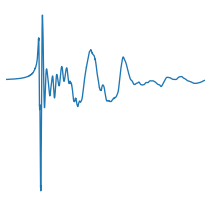

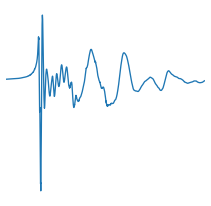

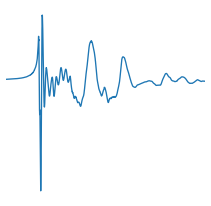

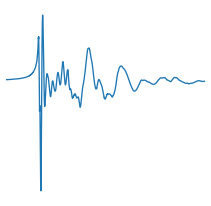

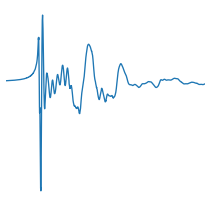

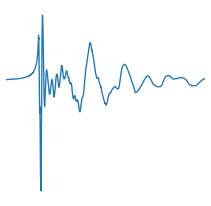

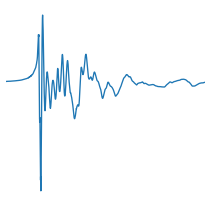

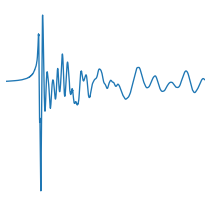

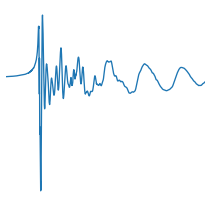

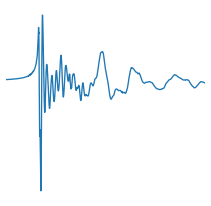

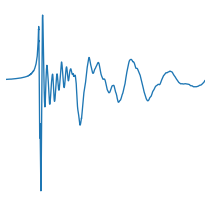

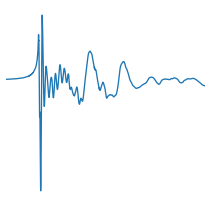

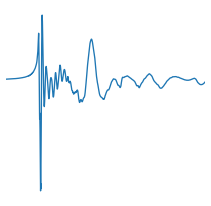

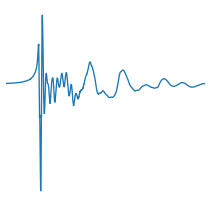

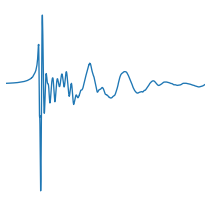

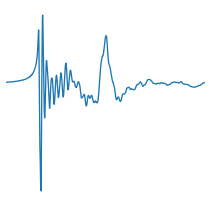

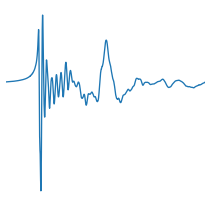

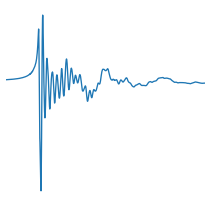

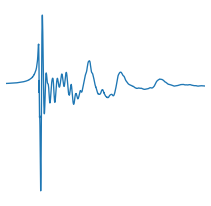

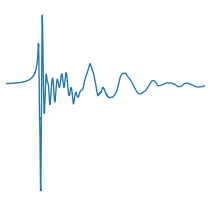

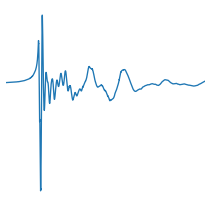

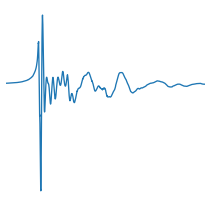

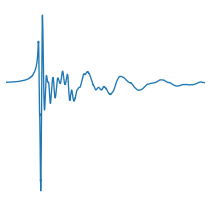

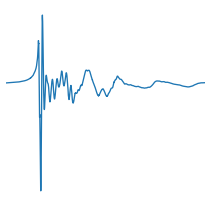

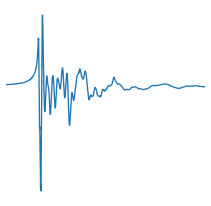

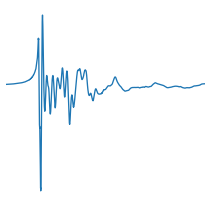

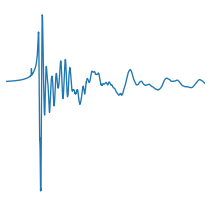

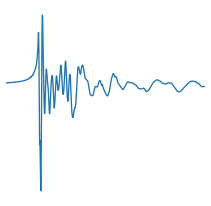

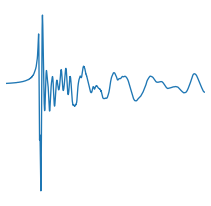

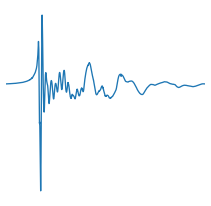

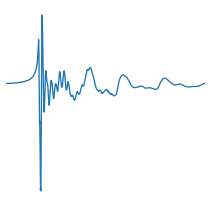

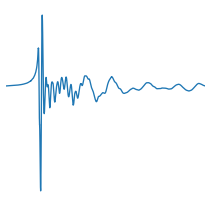

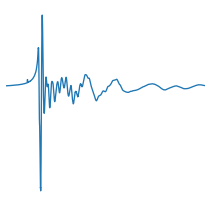

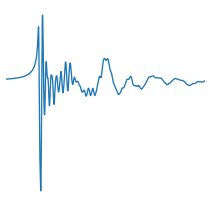

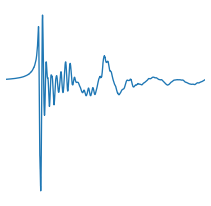

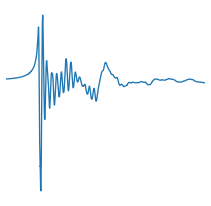

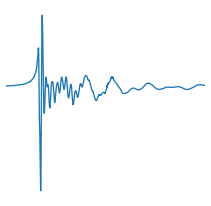

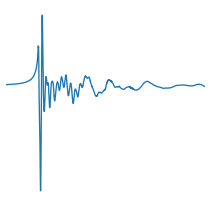

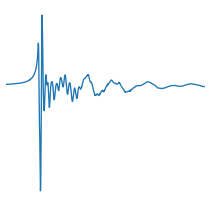

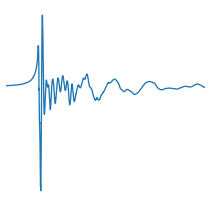

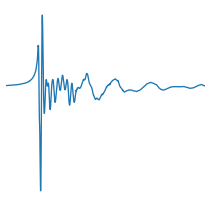

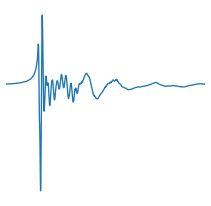

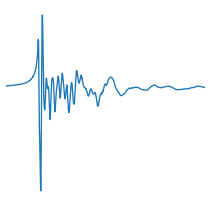

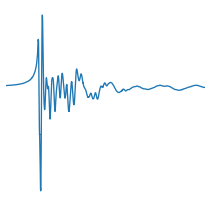

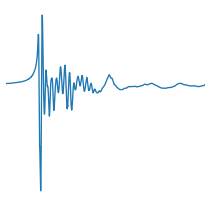

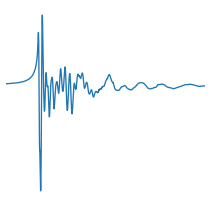

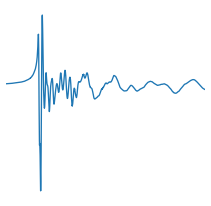

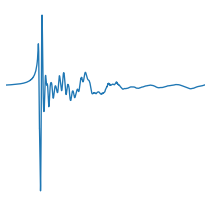

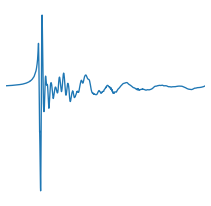

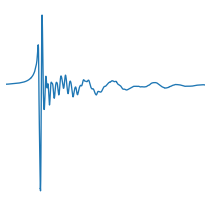

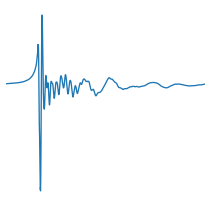

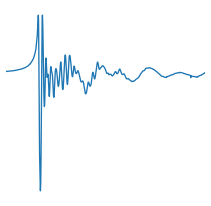

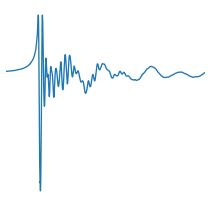

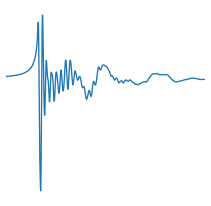

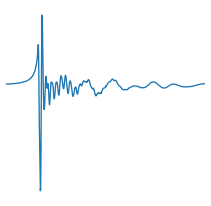

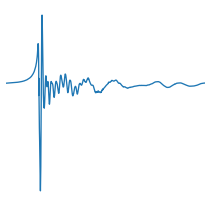

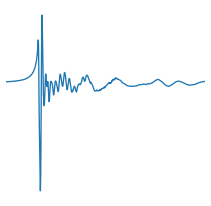

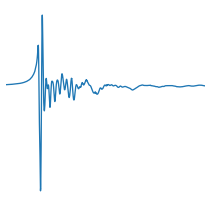

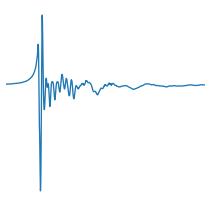

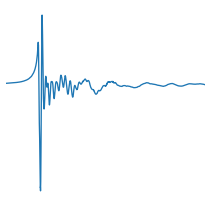

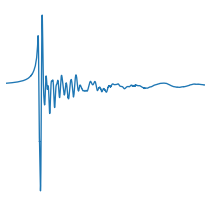

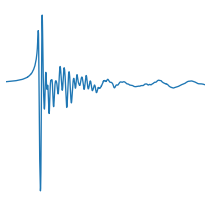

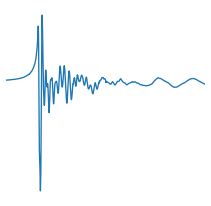

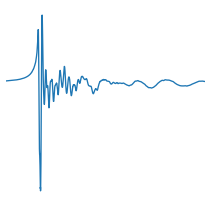

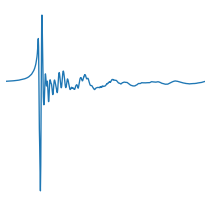

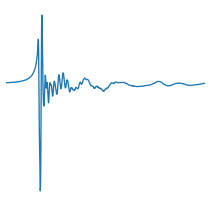

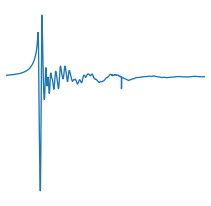

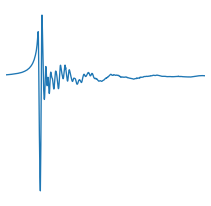

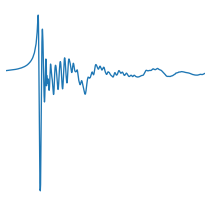

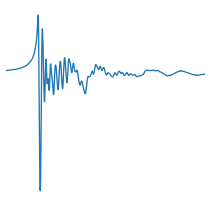

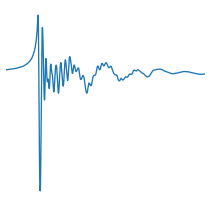

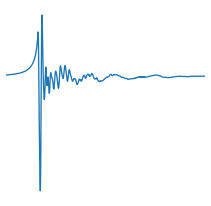

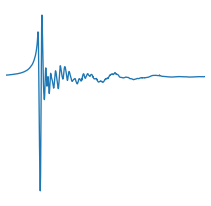

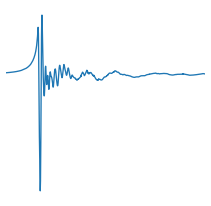

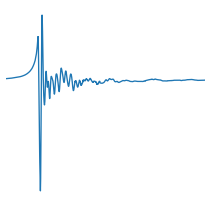

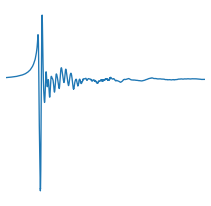

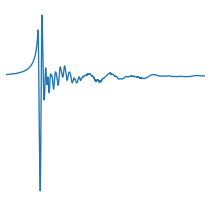

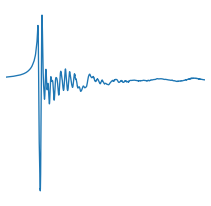

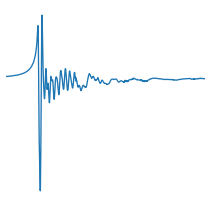

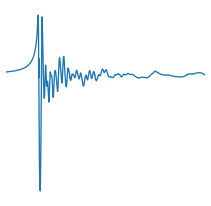

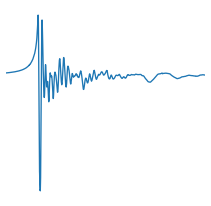

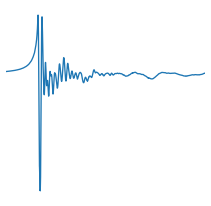

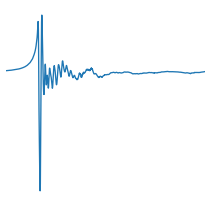

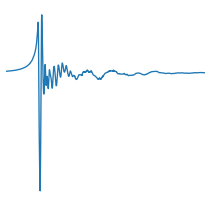

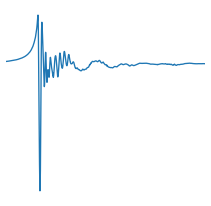

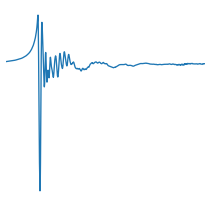

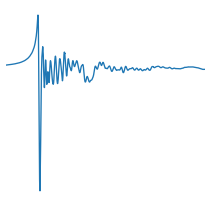

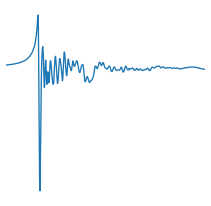

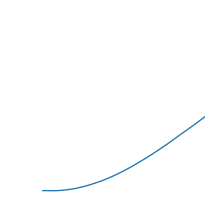

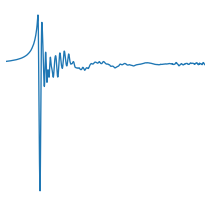

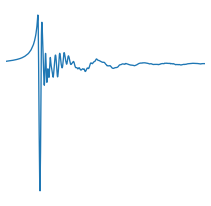

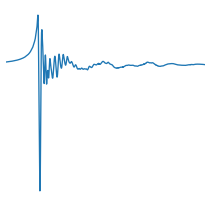

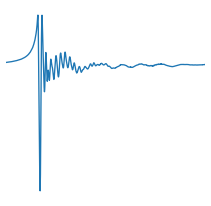

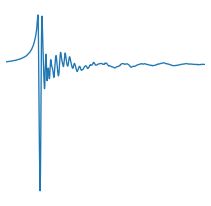

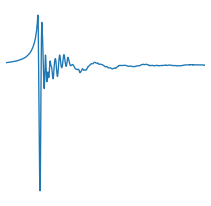

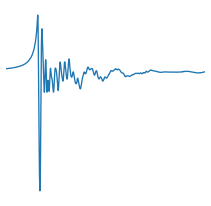

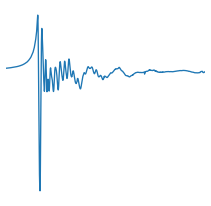

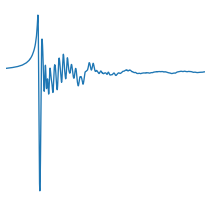

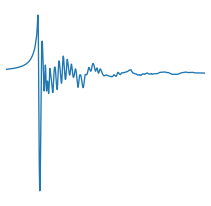

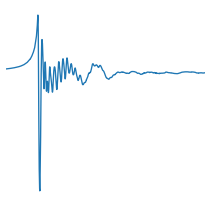

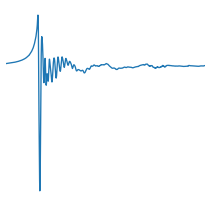

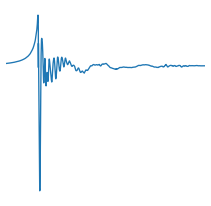

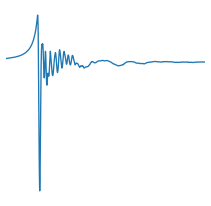

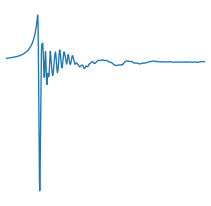

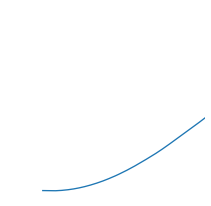

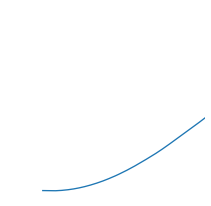

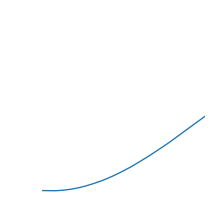

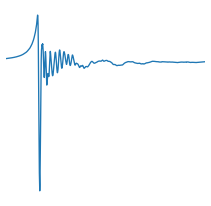

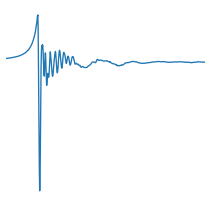

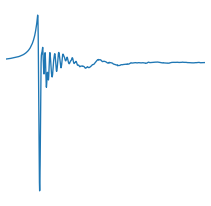

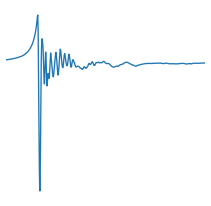

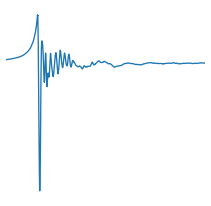

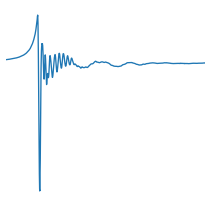

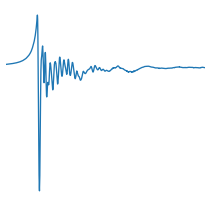

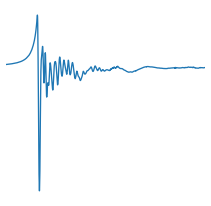

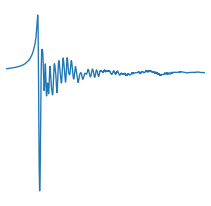

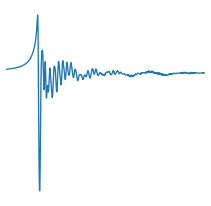

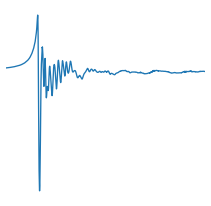

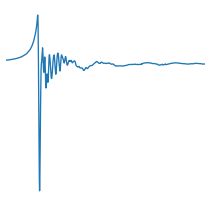

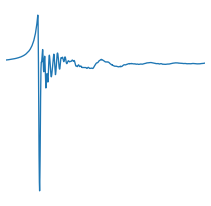

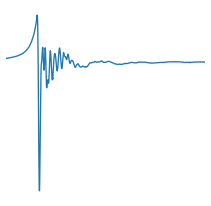

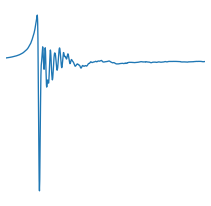

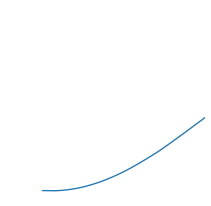

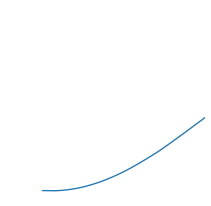

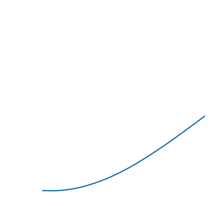

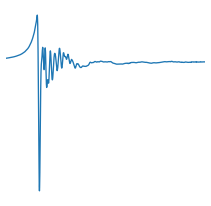

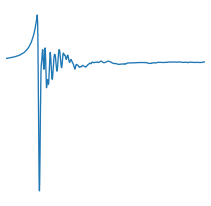

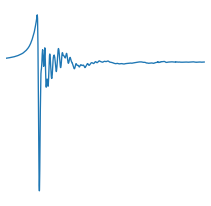

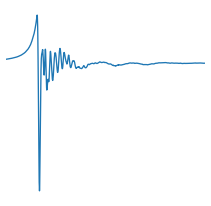

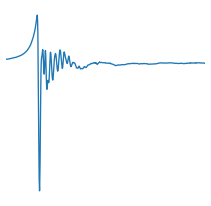

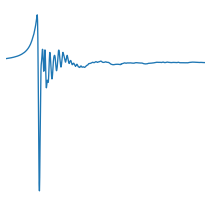

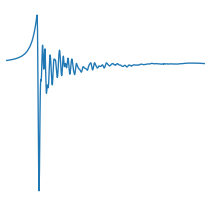

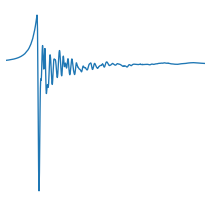

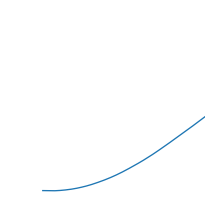

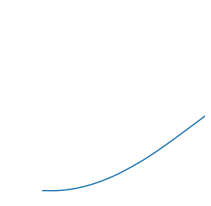

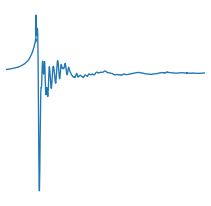

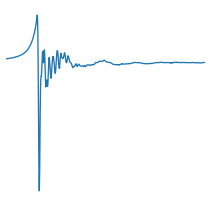

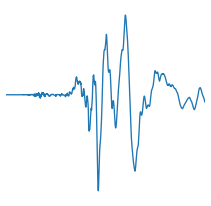

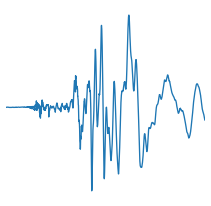

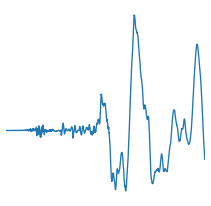

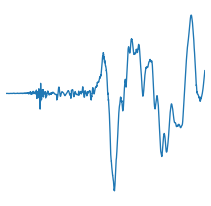

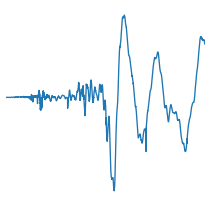

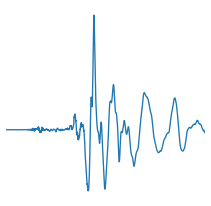

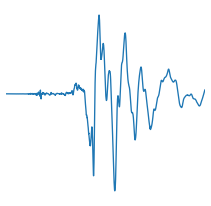

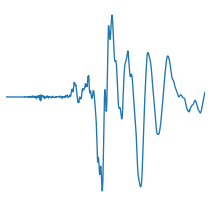

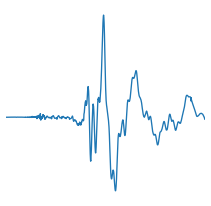

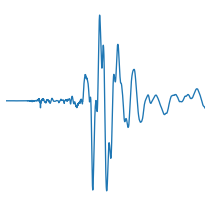

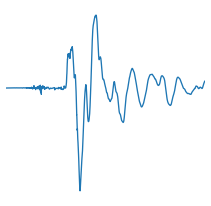

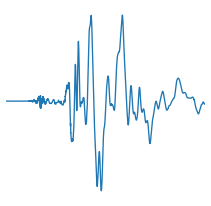

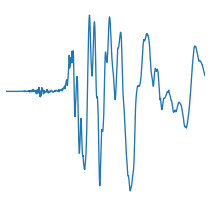

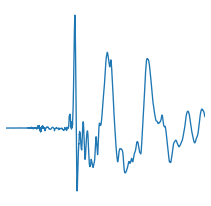

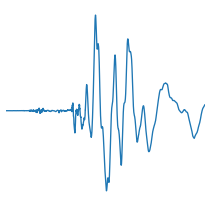

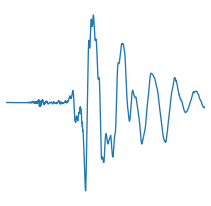

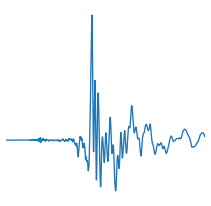

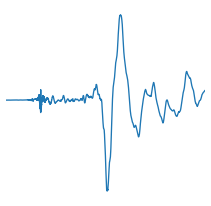

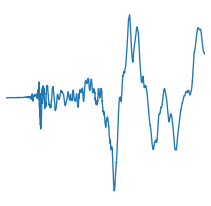

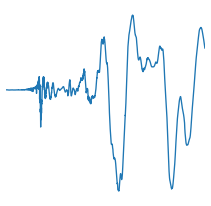

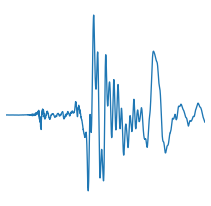

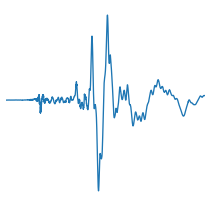

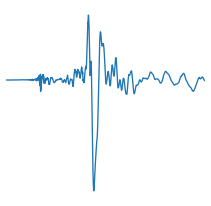

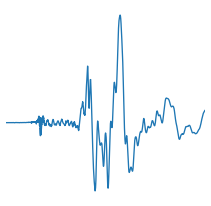

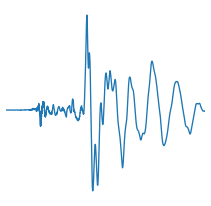

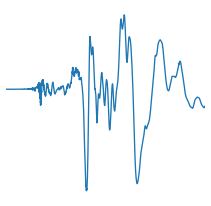

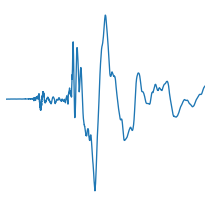

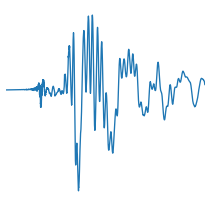

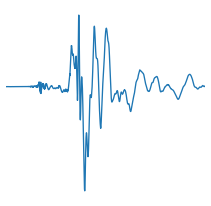

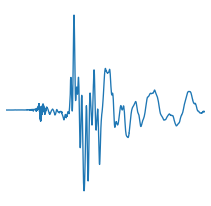

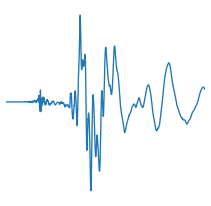

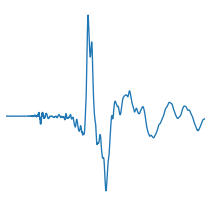

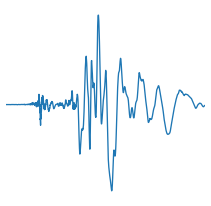

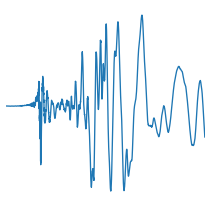

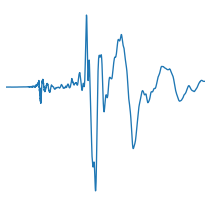

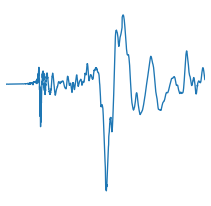

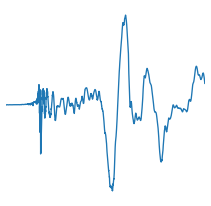

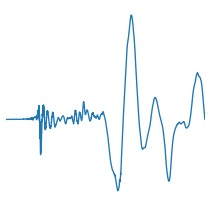

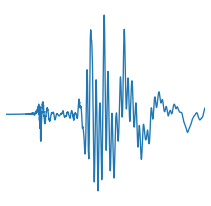

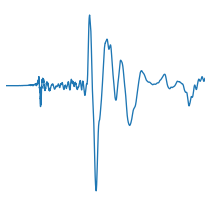

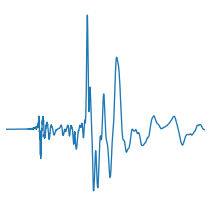

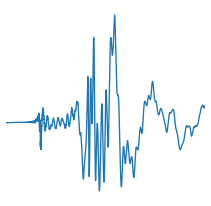

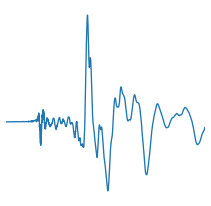

Error in callback <function flush_figures at 0x7fd5acc98e50> (for post_execute):


KeyboardInterrupt: 

In [25]:
#draw the image which is 256*256.
index = 0
index_fail = 0
for item in f['waveforms']:
    if(index != fail_list[index_fail]):
        #for j in range(5):
        x = f['waveforms'][item]['t-tb(s)']
        y = f['waveforms'][item]['strain*dist(cm)']
        y = np.array(y)
        #window = signal.tukey(len(y),0.1)
        #y = y * window
        #b, a = signal.butter(10, 0.25, 'lowpass')
        #y = signal.filtfilt(b, a, y)
        y = y - min(y)
        y = y / max(y)
        #y = signal.resample(y, int(len(y)/16))
        #num_resample = len(y)
        #new_x = []
        #for j in range(num_resample):
            #new_x.append(x[j*16])
        plt.figure(figsize=(4, 4), dpi=64)
        plt.plot(np.array(x),y)
        plt.xlim(-0.02, 0.06)
        plt.axis('off')
        title = "./image_64_newxlim/" + str(index) + ".jpeg"
        plt.savefig(title,dpi=64)
    else:
        index_fail += 1
    index += 1

# Model

In [47]:
#read image data.
from PIL import Image
import numpy as np
data = []
for i in range(1824):
    if(i not in fail_list):
        #for j in range(5):
        title = 'image_64_normalization/'+ str(i) + '.jpeg'
        image = Image.open(title).convert('L')
        data.append(np.array(image))

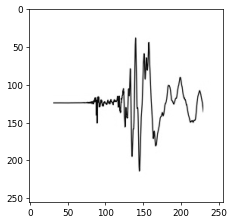

In [48]:
#check the data.
plt.figure(figsize=(4, 4), dpi=64)
plt.imshow(data[0], cmap='gray')

In [49]:
#transform the data type to numpy array
data = np.array(data)
data.shape

(1764, 256, 256)

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import os
import gc

In [52]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.3,random_state=0)

In [53]:
#further split the data into test and validation
X_test, X_validation, y_test, y_validation = train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [54]:
#transfer the data shape for model training
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)
X_validation = X_validation.reshape(X_validation.shape[0], 256, 256, 1)

In [55]:
#using one hot to encode the label.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

In [56]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [82]:
#our model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(256, 256, 1), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(18, activation='softmax'))
optimizer = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [96]:
#paper's model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 1), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(18, activation='softmax'))
optimizer = keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 128)      

In [84]:
#training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=120, batch_size=32)

Epoch 1/120
39/39 [==============================] - 5s 108ms/step - loss: 8.1357 - accuracy: 0.0666 - val_loss: 2.9790 - val_accuracy: 0.0566
Epoch 2/120
39/39 [==============================] - 4s 105ms/step - loss: 3.2902 - accuracy: 0.0610 - val_loss: 2.8888 - val_accuracy: 0.0906
Epoch 3/120
39/39 [==============================] - 4s 106ms/step - loss: 2.9864 - accuracy: 0.0620 - val_loss: 2.8879 - val_accuracy: 0.0981
Epoch 4/120
39/39 [==============================] - 4s 106ms/step - loss: 2.9282 - accuracy: 0.0592 - val_loss: 2.8850 - val_accuracy: 0.0453
Epoch 5/120
39/39 [==============================] - 4s 106ms/step - loss: 2.9293 - accuracy: 0.0649 - val_loss: 2.8882 - val_accuracy: 0.0792
Epoch 6/120
39/39 [==============================] - 4s 106ms/step - loss: 2.9151 - accuracy: 0.0805 - val_loss: 2.8846 - val_accuracy: 0.0755
Epoch 7/120
39/39 [==============================] - 4s 107ms/step - loss: 2.8874 - accuracy: 0.0705 - val_loss: 2.8613 - val_accuracy: 0.0830

Epoch 58/120
39/39 [==============================] - 4s 106ms/step - loss: 0.5579 - accuracy: 0.8137 - val_loss: 0.9998 - val_accuracy: 0.6830
Epoch 59/120
39/39 [==============================] - 4s 106ms/step - loss: 0.5240 - accuracy: 0.8349 - val_loss: 0.9974 - val_accuracy: 0.6792
Epoch 60/120
39/39 [==============================] - 4s 106ms/step - loss: 0.4701 - accuracy: 0.8453 - val_loss: 0.9695 - val_accuracy: 0.6943
Epoch 61/120
39/39 [==============================] - 4s 106ms/step - loss: 0.4866 - accuracy: 0.8672 - val_loss: 0.9607 - val_accuracy: 0.6755
Epoch 62/120
39/39 [==============================] - 4s 106ms/step - loss: 0.4568 - accuracy: 0.8563 - val_loss: 0.9646 - val_accuracy: 0.6679
Epoch 63/120
39/39 [==============================] - 4s 105ms/step - loss: 0.4138 - accuracy: 0.8838 - val_loss: 0.9671 - val_accuracy: 0.6868
Epoch 64/120
39/39 [==============================] - 4s 106ms/step - loss: 0.4439 - accuracy: 0.8627 - val_loss: 0.9593 - val_accuracy:

Epoch 115/120
39/39 [==============================] - 4s 105ms/step - loss: 0.0635 - accuracy: 0.9844 - val_loss: 0.9813 - val_accuracy: 0.7245
Epoch 116/120
39/39 [==============================] - 4s 105ms/step - loss: 0.0568 - accuracy: 0.9902 - val_loss: 1.0010 - val_accuracy: 0.7283
Epoch 117/120
39/39 [==============================] - 4s 108ms/step - loss: 0.0744 - accuracy: 0.9856 - val_loss: 0.9900 - val_accuracy: 0.7358
Epoch 118/120
39/39 [==============================] - 4s 108ms/step - loss: 0.0765 - accuracy: 0.9813 - val_loss: 1.0277 - val_accuracy: 0.7094
Epoch 119/120
39/39 [==============================] - 4s 108ms/step - loss: 0.0620 - accuracy: 0.9896 - val_loss: 1.0156 - val_accuracy: 0.7132
Epoch 120/120
39/39 [==============================] - 4s 107ms/step - loss: 0.0724 - accuracy: 0.9824 - val_loss: 0.9614 - val_accuracy: 0.7396


In [95]:
#check the accuracy.
answer = np.argmax(model.predict(X_validation), axis=1)
answer_onehot = np.zeros((answer.size, answer.max()+1))
answer_onehot[np.arange(answer.size),answer] = 1
answer_decode = label_decode(label_encoder, answer_onehot)
index = 0
correct = 0 
for item in answer_decode:
    if(item == y_validation[index]):
        correct += 1
    index += 1
correct/index

0.7622641509433963

In [93]:
model.save('model_GW_EOS.h5')

In [94]:
model = keras.models.load_model('model_GW_EOS.h5')

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1127526412472308082
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7254036992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11938039282251678381
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
